# layer 중첩해보기

In [1]:
import torch
import torch.nn as nn

In [2]:
X_train = torch.tensor([[0,0],
                      [0,1],
                      [1,0],
                      [1,1.]])

In [3]:
X_train.shape, X_train.dtype

(torch.Size([4, 2]), torch.float32)

In [4]:
y_label = torch.tensor([[0],
                       [0],
                       [0],
                       [1]])
# y_label = torch.tensor([0,0,0,1])

In [5]:
y_label.shape

torch.Size([4, 1])

In [6]:
X_train = torch.rand(32, 4)

In [7]:
linear = nn.Linear(4,3)
x = linear(X_train)
dropout = nn.Dropout()
x = dropout(x)
relu = nn.ReLU()
x = relu(x)

In [8]:
linear2 = nn.Linear(3,2)
softmax = nn.Softmax(dim=1)
x = linear2(x)
softmax(x)

tensor([[0.5371, 0.4629],
        [0.5089, 0.4911],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5289, 0.4711],
        [0.5371, 0.4629],
        [0.4752, 0.5248],
        [0.5242, 0.4758],
        [0.5145, 0.4855],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5176, 0.4824],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5177, 0.4823],
        [0.5371, 0.4629],
        [0.5259, 0.4741],
        [0.5207, 0.4793],
        [0.5371, 0.4629],
        [0.5144, 0.4856],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5371, 0.4629],
        [0.5324, 0.4676]], grad_fn=<SoftmaxBackward0>)

### 배치 사이즈 넣기

In [9]:
batch_size = 64 # 배치변수하나만 지정하고 삽입

In [10]:
50000/batch_size

781.25

In [11]:
image = torch.rand(batch_size, 1, 28, 28)
image.shape

torch.Size([64, 1, 28, 28])

In [12]:
conv = nn.Conv2d(1, 6, 3, padding='same') #vgg-16
x = conv(image)
dropout = nn.Dropout()
x = dropout(x)
relu = nn.ReLU()
x = relu(x)
pool = nn.MaxPool2d(2)
x = pool(x)
x.shape

torch.Size([64, 6, 14, 14])

In [13]:
conv2 = nn.Conv2d(6, 16, 3, padding='same')
dropout2 = nn.Dropout()
x = dropout2(x)
relu2 = nn.ReLU()
x = relu2(x)
x = conv2(x)
x.shape

torch.Size([64, 16, 14, 14])

In [14]:
conv3 = nn.Conv2d(16, 128, 3, padding='same')
x = conv3(x)
pool2 = nn.MaxPool2d(2)
x = pool2(x)
x.shape

torch.Size([64, 128, 7, 7])

In [15]:
flatten = nn.Flatten()
x = flatten(x)
x.shape

torch.Size([64, 6272])

In [16]:
linear = nn.Linear(6272,2)
x = linear(x)
softmax = nn.Softmax(dim=1)
pred = softmax(x)
pred.shape

torch.Size([64, 2])

In [17]:
y_label = torch.rand(64, 2)

In [18]:
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(pred, y_label)
loss.backward()

In [19]:
from torch.optim as optim
optim.Adam(model, parameter(), lr=0.001)

SyntaxError: invalid syntax (674571925.py, line 1)

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [16]:
cat_directory = r'data/dogs-vs-cats/Cat/'
dog_directory = r'data/dogs-vs-cats/Dog'

cat_image_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_image_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_image_filepaths, *dog_image_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [17]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

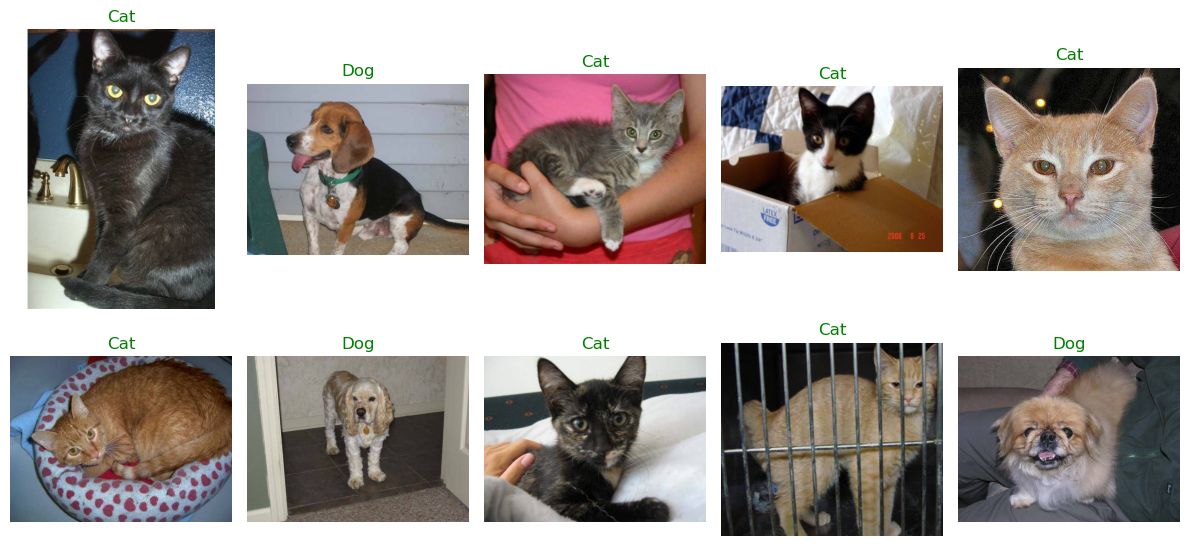

In [18]:
display_image_grid(test_images_filepaths)

In [19]:
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):       
        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [20]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [21]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
('Dog\\dog', 'Dog\\dog', 'Dog\\dog', 0, 'Dog\\dog', 'Dog\\dog', 'Dog\\dog', 0, 'Dog\\dog', 'Dog\\dog', 'Dog\\dog', 'Dog\\dog', 'Dog\\dog', 0, 0, 'Dog\\dog', 'Dog\\dog', 0, 0, 'Dog\\dog', 'Dog\\dog', 'Dog\\dog', 'Dog\\dog', 'Dog\\dog', 'Dog\\dog', 'Dog\\dog', 0, 0, 0, 0, 'Dog\\dog', 0)


In [23]:
class LeNet5(nn.Module):

    def __init__(self):

        super(LeNet5, self).__init__()

        self.features = nn.Sequential(nn.Conv2d(1, 6, 5, padding='same'),

                       nn.ReLU(),

                       nn.MaxPool2d(2),

                       nn.Conv2d(6, 16, 5, padding='same'),

                       nn.ReLU(),

                       nn.MaxPool2d(2),

                       nn.Conv2d(16, 126, 5, padding='same'),

                       nn.ReLU(),

                       nn.MaxPool2d(2))

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(nn.Linear(126*3*3 , 128),

                                        nn.ReLU(),

                                        nn.Linear(128, 64),

                                        nn.ReLU(),

                                        nn.Linear(64, 10),

                                        nn.Softmax(dim=1))



    def forward(self, x):

        x = self.features(x)

        #print(x.shape)

        x =self.flatten(x)

        x = self.classifier(x)

        return x